In [5]:
import sys
sys.path.insert(0, 'C:/Udvikler/Speciale/ThesisCode')
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from utils import * 

In [6]:
features_statistics = ["Price", "DealersInCompetition", "Spread", "Duration", "Amount", "AllQMeanMid"]
features = ["DealersInCompetition", "Side", "Spread", "AllQMeanMid", "Result", "FirmAccount", "Duration", "BookName", "Inventory", "BPV_Risk", "Amount"]

# Read the CSV file into a pandas DataFrame
file_path = "../data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [7]:
def add_direction_column(df):
    df["Direction"] = df["Side"].apply(lambda x: -1 if x == "BUY" else 1)
    df["Direction"] = df["Direction"].astype(float)
    return df

def add_spread_column(df):
    df["Spread"] = df["Direction"] * (df["Price"]-df["Mid"])
    return df

df = add_direction_column(df)
df = add_spread_column(df)

# Rename columns
df = df.rename(columns={
    "inventoryRisk": "Inventory",
    "bpv_risk": "BPV_Risk"
})

### Basic summary

In [8]:
# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")
df.sort_values('TradeTime', inplace=True)

print(df["TradeTime"].head(1))
print(df["TradeTime"].tail(1))

3131   2023-03-20 10:01:00
Name: TradeTime, dtype: datetime64[ns]
1162   2024-07-22 15:42:39
Name: TradeTime, dtype: datetime64[ns]


In [9]:

nan_count = df['TradedPrice'].isna().sum()
total_rows = len(df)
nan_share = nan_count / total_rows
print("Share of trades with no traded price", round(nan_share,2))


nan_or_zero_counts = df[df["CoverPrice"] == 0 | df['TradedPrice'].isna()]
nan_share = len(nan_or_zero_counts) / total_rows
print("Share of trades with no target price", round(nan_share,2))

Share of trades with no traded price 0.1
Share of trades with no target price 0.37


count    6256.000000
mean        0.040094
std         0.099374
min        -0.899000
25%         0.011000
50%         0.022000
75%         0.043000
max         3.299000
Name: Spread, dtype: float64
difference betweeen max and min value:  4.1980000000000075
Share of JyskeBank prices on wrong side of mid 0.0879156010230179


<Axes: xlabel='Spread', ylabel='Count'>

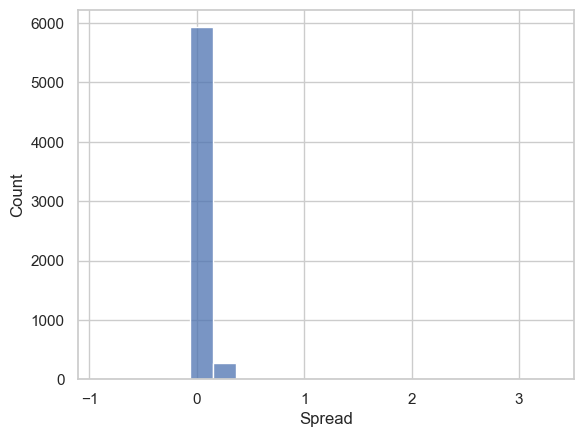

In [10]:
df["Direction"] = df["Side"].apply(lambda x: -1 if x == "BUY" else 1)
df["Direction"] = df["Direction"].astype(float)

# Create actions as spread  independent of the side (using "Direction"). Should I use ALLQ average as mid? 
df["Spread"] = df["Direction"] * (df["Price"]-df["Mid"])

#Look at distribution of actions
print(df.Spread.describe())
print("difference betweeen max and min value: ", np.max(df["Spread"])-np.min(df["Spread"]))
print("Share of JyskeBank prices on wrong side of mid", len(df[df["Spread"] < 0]) / len(df))

sns.set_theme(style="whitegrid")
sns.histplot(df["Spread"], bins=20)


In [11]:
buy_over_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'BUY') & (df["TradedPrice"] > df["Mid"]))
sell_under_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'SELL') & (df["TradedPrice"] < df["Mid"]))
prop = len(df[buy_over_mid | sell_under_mid]) / len(df[df['TradedPrice'] > 0])
print("Share of trades on wrong side of price capture mid", round(prop,3))

buy_over_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'BUY') & (df["TradedPrice"] > df['AllQMeanMid'] + df["Mid"]))
sell_under_mid = ((df['TradedPrice'] > 0) & (df['Side'] == 'SELL') & (df["TradedPrice"] < df['AllQMeanMid'] + df["Mid"]))
prop = len(df[buy_over_mid | sell_under_mid]) / len(df[df['TradedPrice'] > 0])
print("Share of trades on wrong side of AllQ mean mid", round(prop, 3))

Share of trades on wrong side of price capture mid 0.312
Share of trades on wrong side of AllQ mean mid 0.343


In [12]:
#Unique number of bonds and clients
unique_count = df['Isin'].nunique() 
print(f'Number of unique values in column ISIN: {unique_count}')

unique_count = df['ClientFirm'].nunique()  
print(f'Number of unique values in column ClientFirm: {unique_count}')

Number of unique values in column ISIN: 182
Number of unique values in column ClientFirm: 40


In [13]:
binaries = ['Result', 'Side', 'BookName']

for feature in binaries:# Calculate value counts
    value_counts = df[feature].value_counts()

    # Calculate total number of observations
    total_observations = len(df)

    # Calculate share of each unique value
    share = value_counts / total_observations

    print(f'{feature} share: {share} \n')

Result share: Result
Lost    0.737212
Won     0.262788
Name: count, dtype: float64 

Side share: Side
SELL    0.597986
BUY     0.402014
Name: count, dtype: float64 

BookName share: BookName
LANGFLEX    0.504316
KORTMM      0.495684
Name: count, dtype: float64 



In [14]:
#Summary of context features
df_statistics = df[features_statistics]

lower_spread_limit = -0.05
upper_spread_limit = 0.2

df_statistics = df_statistics[(df_statistics.Spread > lower_spread_limit) & (df_statistics.Spread < upper_spread_limit)]

print("DataFrame shape:", df_statistics.shape)
#print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df_statistics.describe())

DataFrame shape: (6035, 6)

Summary statistics:
              Price  DealersInCompetition       Spread     Duration  \
count  6035.000000           6035.000000  6035.000000  6035.000000   
mean     97.108794              2.983596     0.031643     1.601214   
std       3.224086              1.331235     0.036210     1.191913   
min      82.020000              1.000000    -0.049000     0.010683   
25%      94.884000              2.000000     0.011000     0.696101   
50%      97.977000              3.000000     0.021000     1.224308   
75%     100.080000              4.000000     0.042000     2.362030   
max     101.493000              9.000000     0.200000    10.286949   

             Amount  AllQMeanMid  
count  6.035000e+03  6035.000000  
mean   2.196121e+07    -0.002249  
std    4.767498e+07     0.033698  
min    1.000000e+03    -0.800000  
25%    1.000000e+06    -0.009500  
50%    4.000000e+06     0.000667  
75%    1.900000e+07     0.009200  
max    5.000000e+08     0.718000  


In [15]:
df_margins = calculate_margins(df)
nan_count = df_margins['TargetPrice'].isna().sum()
total_rows = len(df_margins)
nan_share = nan_count / total_rows
print("Share of trades with no target price", round(nan_share,2))

Share of trades with no target price 0.1


In [16]:
#How is the distribution of ISINS
isinCount = df.Isin.value_counts()
print(isinCount)

Isin
DK0009507931    253
DK0009515363    245
DK0009296469    226
DK0009295149    216
DK0009295222    198
               ... 
DK0004610599      1
DK0006345228      1
DK0004620390      1
DK0009541609      1
DK0002060672      1
Name: count, Length: 182, dtype: int64


In [17]:
#Summary of context features. Before spread clamping
df = df[features]
print("DataFrame shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe())


DataFrame shape: (6256, 11)

Column names:
 Index(['DealersInCompetition', 'Side', 'Spread', 'AllQMeanMid', 'Result',
       'FirmAccount', 'Duration', 'BookName', 'Inventory', 'BPV_Risk',
       'Amount'],
      dtype='object')

Data types:
 DealersInCompetition      int64
Side                     object
Spread                  float64
AllQMeanMid             float64
Result                   object
FirmAccount              object
Duration                float64
BookName                 object
Inventory               float64
BPV_Risk                float64
Amount                  float64
dtype: object

Summary statistics:
        DealersInCompetition       Spread  AllQMeanMid     Duration  \
count           6256.000000  6256.000000  6256.000000  6256.000000   
mean               2.990090     0.040094    -0.002148     1.635348   
std                1.322944     0.099374     0.039133     1.246938   
min                1.000000    -0.899000    -0.800000     0.010683   
25%                

In [18]:
#After clamping
df = df[(df.Spread > lower_spread_limit) & (df.Spread < upper_spread_limit)]
print("DataFrame shape:", df.shape)
print("\nColumn names:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nSummary statistics:\n", df.describe())

DataFrame shape: (6035, 11)

Column names:
 Index(['DealersInCompetition', 'Side', 'Spread', 'AllQMeanMid', 'Result',
       'FirmAccount', 'Duration', 'BookName', 'Inventory', 'BPV_Risk',
       'Amount'],
      dtype='object')

Data types:
 DealersInCompetition      int64
Side                     object
Spread                  float64
AllQMeanMid             float64
Result                   object
FirmAccount              object
Duration                float64
BookName                 object
Inventory               float64
BPV_Risk                float64
Amount                  float64
dtype: object

Summary statistics:
        DealersInCompetition       Spread  AllQMeanMid     Duration  \
count           6035.000000  6035.000000  6035.000000  6035.000000   
mean               2.983596     0.031643    -0.002249     1.601214   
std                1.331235     0.036210     0.033698     1.191913   
min                1.000000    -0.049000    -0.800000     0.010683   
25%                

### Numeric features exploration

BookName
KORTMM      1.051004e+07
LANGFLEX    1.979514e+06
Name: Inventory, dtype: float64


<Axes: xlabel='Inventory', ylabel='Count'>

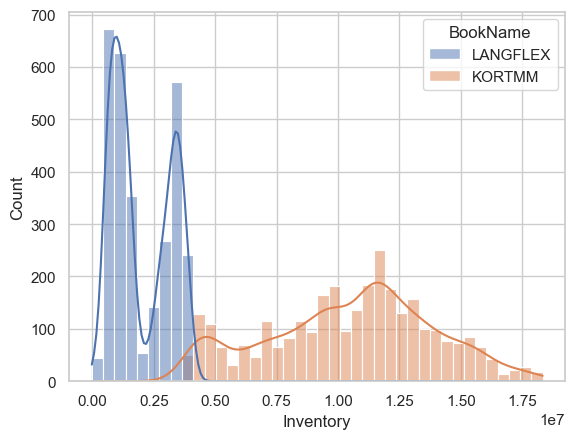

In [19]:
# Calculate the mean of 'Inventory' for each portfolio based on 'Type'
mean_inventory_per_portfolio = df.groupby('BookName')['Inventory'].mean()

# Print the result
print(mean_inventory_per_portfolio)

sns.histplot(data=df, x='Inventory', hue='BookName', kde=True, bins=40)


       DealersInCompetition       Spread  AllQMeanMid     Duration  \
count           6035.000000  6035.000000  6035.000000  6035.000000   
mean               2.983596     0.031643    -0.002249     1.601214   
std                1.331235     0.036210     0.033698     1.191913   
min                1.000000    -0.049000    -0.800000     0.010683   
25%                2.000000     0.011000    -0.009500     0.696101   
50%                3.000000     0.021000     0.000667     1.224308   
75%                4.000000     0.042000     0.009200     2.362030   
max                9.000000     0.200000     0.718000    10.286949   

          Inventory       BPV_Risk        Amount  
count  6.035000e+03    6035.000000  6.035000e+03  
mean   6.309091e+06   27882.591296  2.196121e+07  
std    4.967538e+06   22269.144108  4.767498e+07  
min   -2.476052e+04  -10256.143621  1.000000e+03  
25%    1.510549e+06   13241.542572  1.000000e+06  
50%    4.081630e+06   21256.845693  4.000000e+06  
75%    1.102

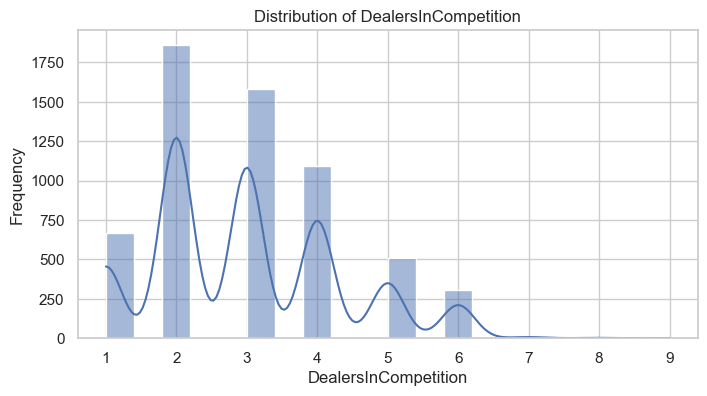

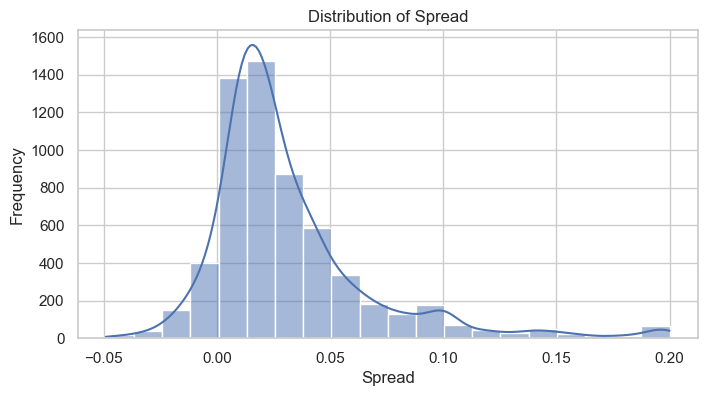

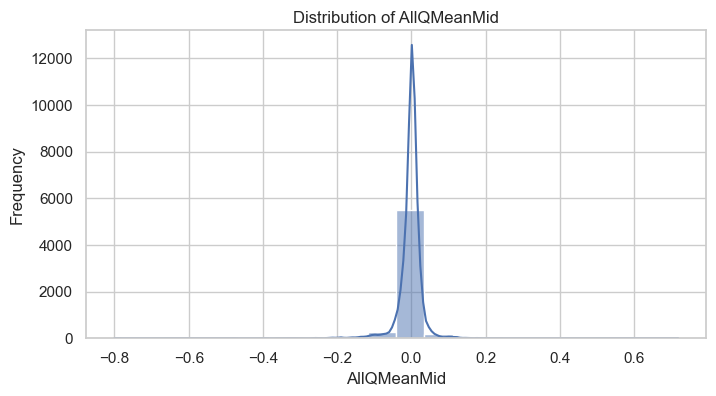

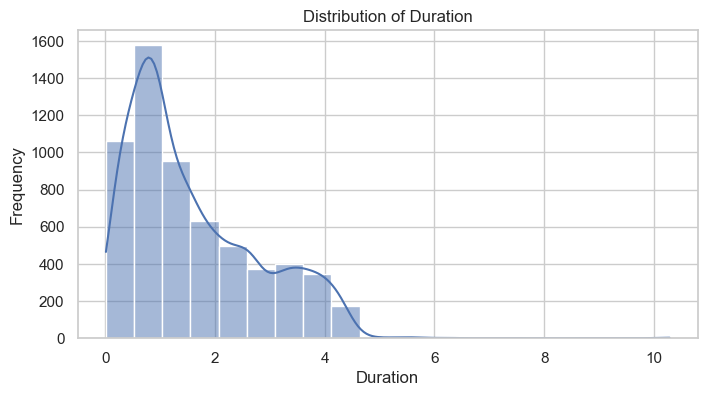

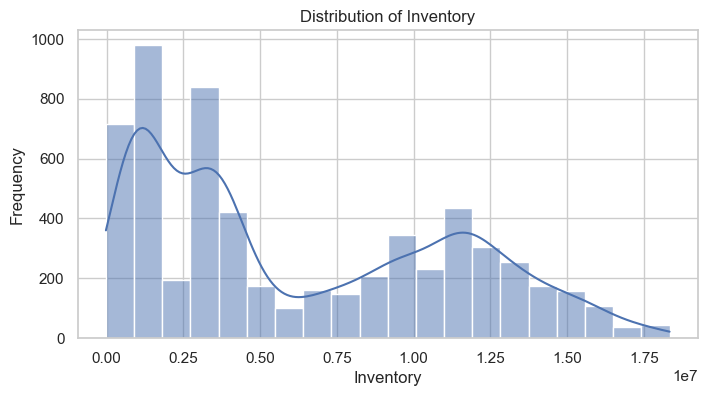

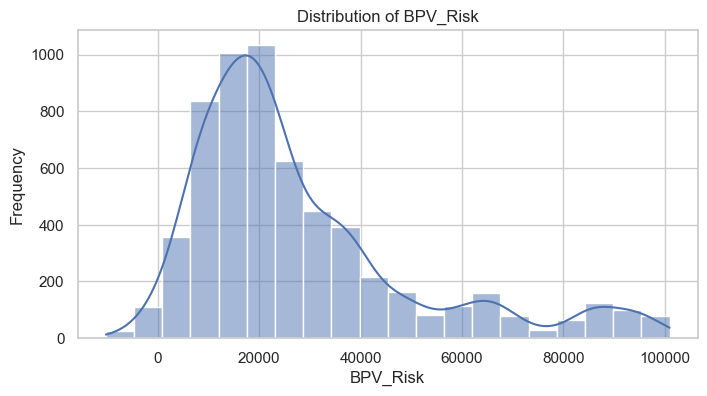

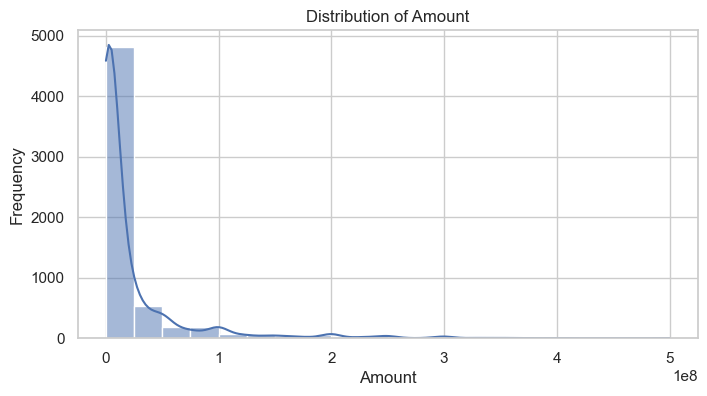

In [20]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
print(df[numeric_columns].describe())

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


In [21]:
numeric_columns

Index(['DealersInCompetition', 'Spread', 'AllQMeanMid', 'Duration',
       'Inventory', 'BPV_Risk', 'Amount'],
      dtype='object')

In [22]:
numeric_columns_and_side = numeric_columns.tolist()
numeric_columns_and_side.append('Result')
custom_palette = ['royalblue', 'firebrick']


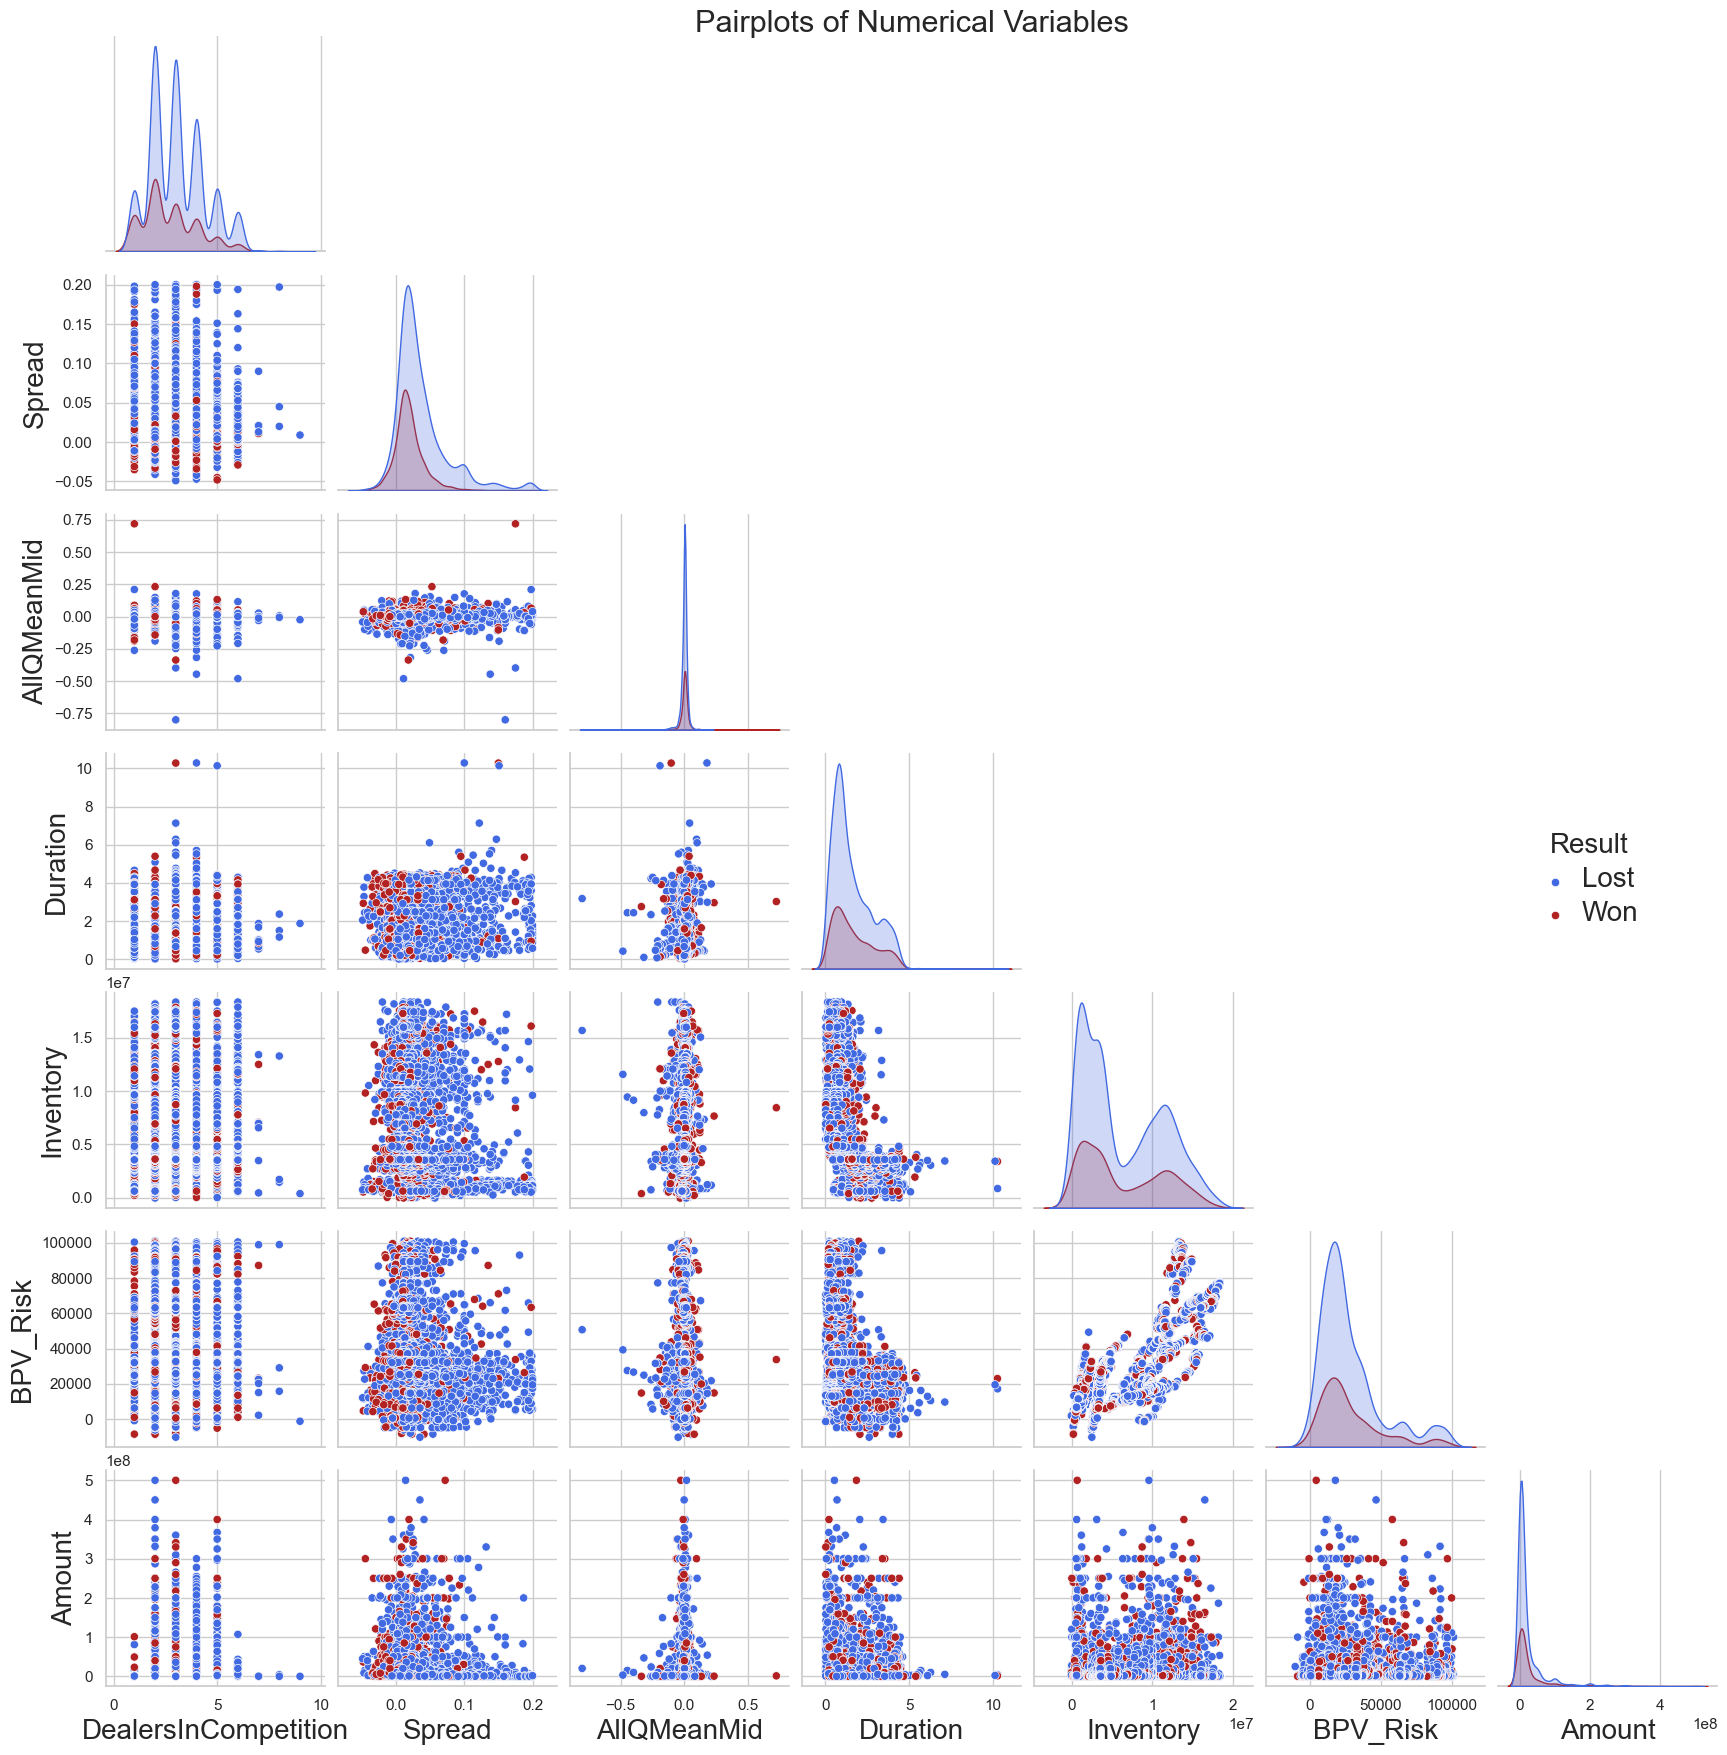

In [36]:
pairplot = sns.pairplot(df[numeric_columns_and_side], hue='Result', corner=True, palette=custom_palette)
pairplot.figure.suptitle("Pairplots of Numerical Variables", y=1, fontsize=22)  
pairplot._legend.set_bbox_to_anchor((0.9, 0.5))  
pairplot._legend.set_title("Result")  
pairplot._legend.get_title().set_fontsize(20)
pairplot._legend.get_frame().set_edgecolor('black') 
pairplot._legend.get_frame().set_linewidth(1.5)  
for text in pairplot._legend.texts:
    text.set_fontsize(20)  

for ax in pairplot.axes.flat:
    if ax:  
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
        ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.show()

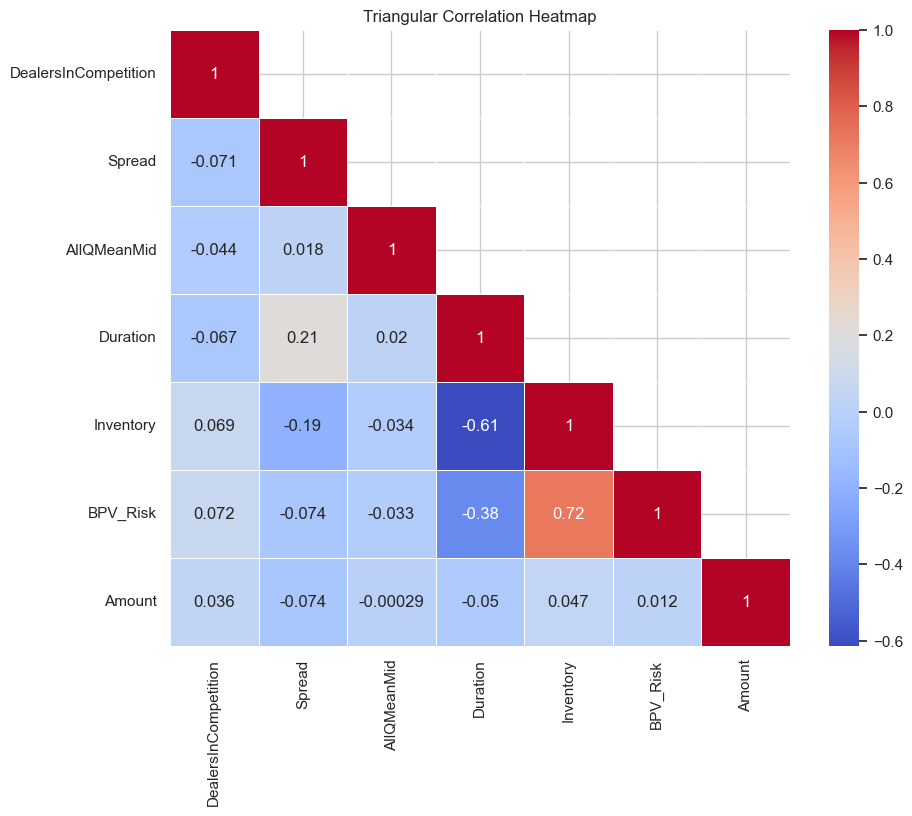

In [25]:
# Calculate correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Create a mask for the upper triangle excluding the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Triangular Correlation Heatmap")
plt.show()

### Categorical features exploration

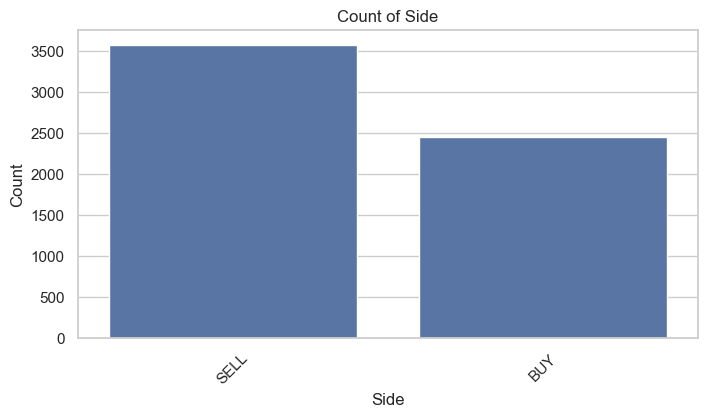

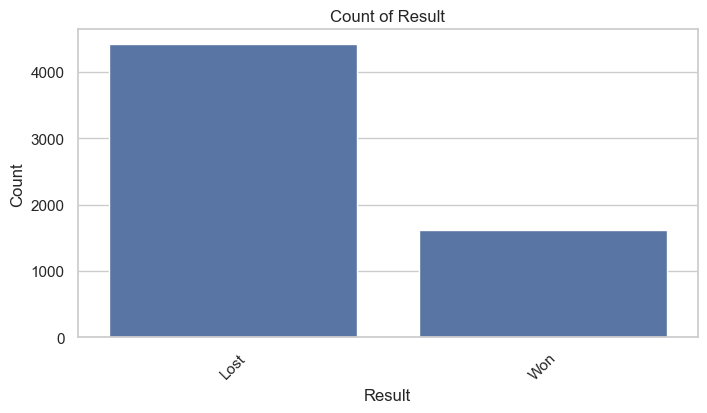

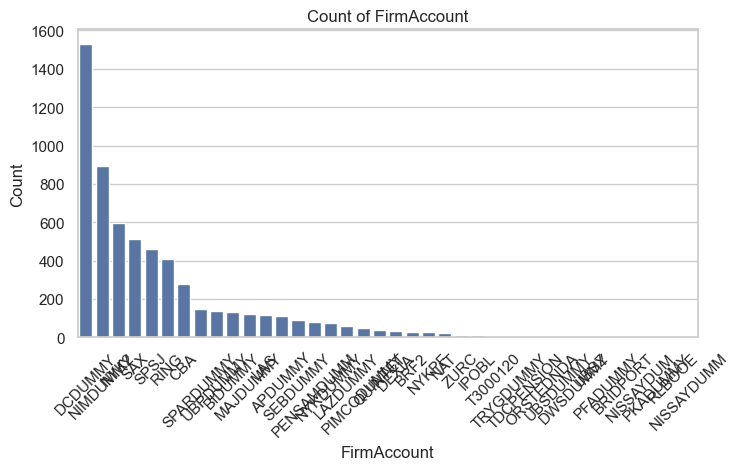

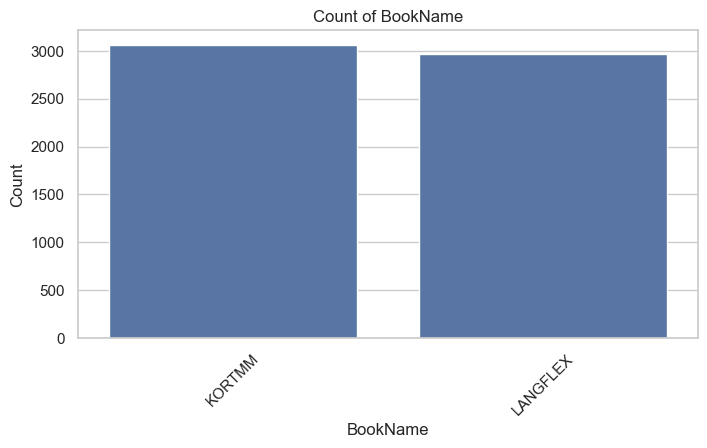

In [26]:
categorical_columns = df.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()


### Group FirmAccounts which has small frequency into other group

In [27]:
df['FirmAccount'].value_counts(normalize=True)

FirmAccount
DCDUMMY       0.253355
NIMDUMMY      0.147970
NYK2          0.098592
SAX           0.085004
SPSJ          0.076222
RING          0.068103
CBA           0.046065
SPARDUMMY     0.024524
UBPDUMMY      0.022701
BIDUMMY       0.022204
MAJDUMMY      0.020050
LAS           0.019056
APDUMMY       0.018724
SEBDUMMY      0.015244
PENSAMDUMM    0.012925
NYKDUMMY      0.012262
LAZDUMMY      0.010273
PIMCODUMMY    0.008451
QUINTET       0.006297
DEXIA         0.005634
BRF2          0.004971
NYKPF         0.004640
NAT           0.003977
ZURC          0.002486
IPOBL         0.001823
T3000120      0.001326
TRYGDUMMY     0.001326
TDCPENSION    0.001160
ORSTEDNDA     0.000829
UBSDUMMY      0.000829
DWSDUMMY      0.000663
UBSZ          0.000663
PFADUMMY      0.000497
BRIDPORT      0.000497
NISSAYDUM     0.000166
PKADUMMY      0.000166
RLBOOE        0.000166
NISSAYDUMM    0.000166
Name: proportion, dtype: float64

In [28]:
df['FirmAccount'] = df['FirmAccount'].mask(df['FirmAccount'].map(df['FirmAccount'].value_counts(normalize=True)) < 0.03, 'Other')

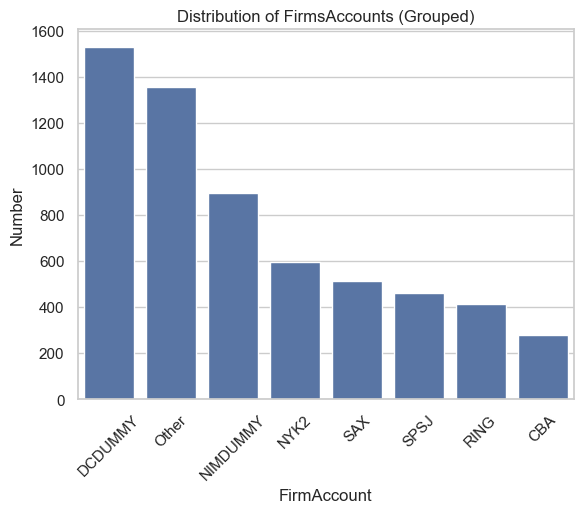

C:\Users\JB4846\AppData\Local\Temp\ipykernel_31304\3142536630.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


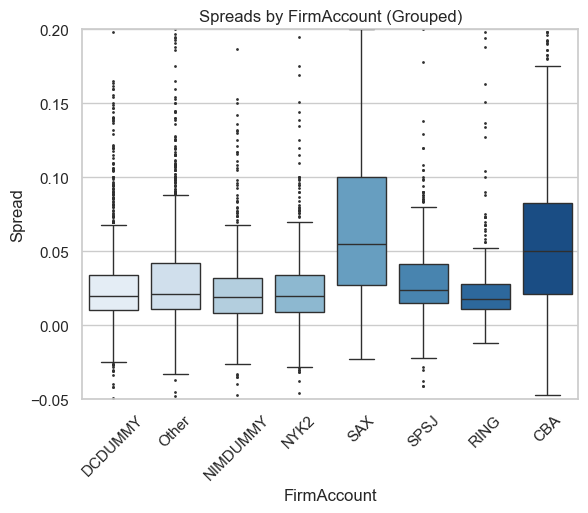

In [38]:
# Define the sorted order based on the barplot
sorted_order = df['FirmAccount'].value_counts().index

# Barplot: Use the sorted order
#plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='FirmAccount', order=sorted_order)
plt.title("Distribution of FirmsAccounts (Grouped)")
plt.xlabel("FirmAccount")
plt.ylabel("Number")
plt.xticks(rotation=45)
plt.show()

# Function to plot boxplot
def plot_box_cat(dep, var, df, palette=None, order=None):
    data = pd.concat((df[dep], df[var]), axis=1)
    sns.boxplot(
        x=var,
        y=dep,
        data=data,
        palette=palette if palette is not None else 'Blues',
        fliersize=1,  # Size of outliers
        order=order   # Use the same sorted order
    )
    plt.title("Spreads by FirmAccount (Grouped)")
    plt.ylim([-0.05, 0.2])
    plt.xticks(rotation=45)

# Boxplot: Use the same sorted order
plot_box_cat('Spread', 'FirmAccount', df, order=sorted_order)
plt.xlabel('FirmAccount')
plt.show()